In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import datetime
import os

import numpy as np
import matplotlib.pyplot as plt

In [2]:
test = tf.keras.utils.image_dataset_from_directory(
    '../Dataset/test',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    batch_size=1,
    shuffle=False
)

Found 2500 files belonging to 25 classes.


In [3]:
def generate_model(conv_layers, dense_layers):    
    img_input = tf.keras.layers.Input(shape=(224, 224, 3))
    x = tf.keras.layers.BatchNormalization()(img_input)
    
    for filters, kernel_size, depth, pool in conv_layers:
        shortcut = tf.keras.layers.Conv2D(filters, 1, activation='relu')(x)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
        
        for i in range(depth):
            x = tf.keras.layers.Conv2D(                
                filters,
                kernel_size,
                activation='relu',
                padding='same'
            )(x)
            x = tf.keras.layers.BatchNormalization()(x)
                
        x = tf.keras.layers.Add()([shortcut,x])
        x = tf.keras.layers.Activation('relu')(x)
            
        if pool > 1:
            x = tf.keras.layers.MaxPool2D(
                pool_size=pool
            )(x)
            
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Flatten()(x)
    
    for units in dense_layers:
        x = tf.keras.layers.Dense(
            units,
            activation='relu'
        )(x)
    
    x = tf.keras.layers.Dense(
        25,
        activation='softmax'
    )(x)
    
    
    model = tf.keras.Model(img_input, x)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    return model

In [8]:
def run(id):    
    json = ''
    with open(f'models/{id}.json', 'r') as json_file:
        json = json_file.read()
    
    model = tf.keras.models.model_from_json(json)
    model.load_weights(f'checkpoints/{id}')
        
    plt.figure(figsize=(15, 20))
    for i in range(len(test.class_names)):
        for images, label in test.filter(lambda x, l: tf.math.equal(tf.math.argmax(l[0]), i)).take(1):
            prediction = model.predict(images)
            sorted_prediction = np.argsort(np.max(prediction, axis=0))
            
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[0, ...].numpy().astype("uint8"))
            plt.title(f"""
GT: {test.class_names[np.argmax(label[0].numpy())]}
1st: {test.class_names[sorted_prediction[-1]]} {round(prediction[0, sorted_prediction[-1]] * 100)}%
2nd: {test.class_names[sorted_prediction[-2]]} {round(prediction[0, sorted_prediction[-2]] * 100)}%
""")
            plt.axis('off')
    
    #correct_predictions = dict.fromkeys(test.class_names, 0)
    #for images, labels in test:
    #    predictions = model.predict(images)
    #    for i in range(len(predictions)):
    #        label_class = np.argmax(labels[i])
    #        prediction_class = np.argmax(predictions[i])
    #
    #        if label_class == prediction_class:
    #            correct_predictions[test.class_names[label_class]] += 1
    #    
    #for k in correct_predictions:
    #    print(f'{k};{correct_predictions[k] / 100}')

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


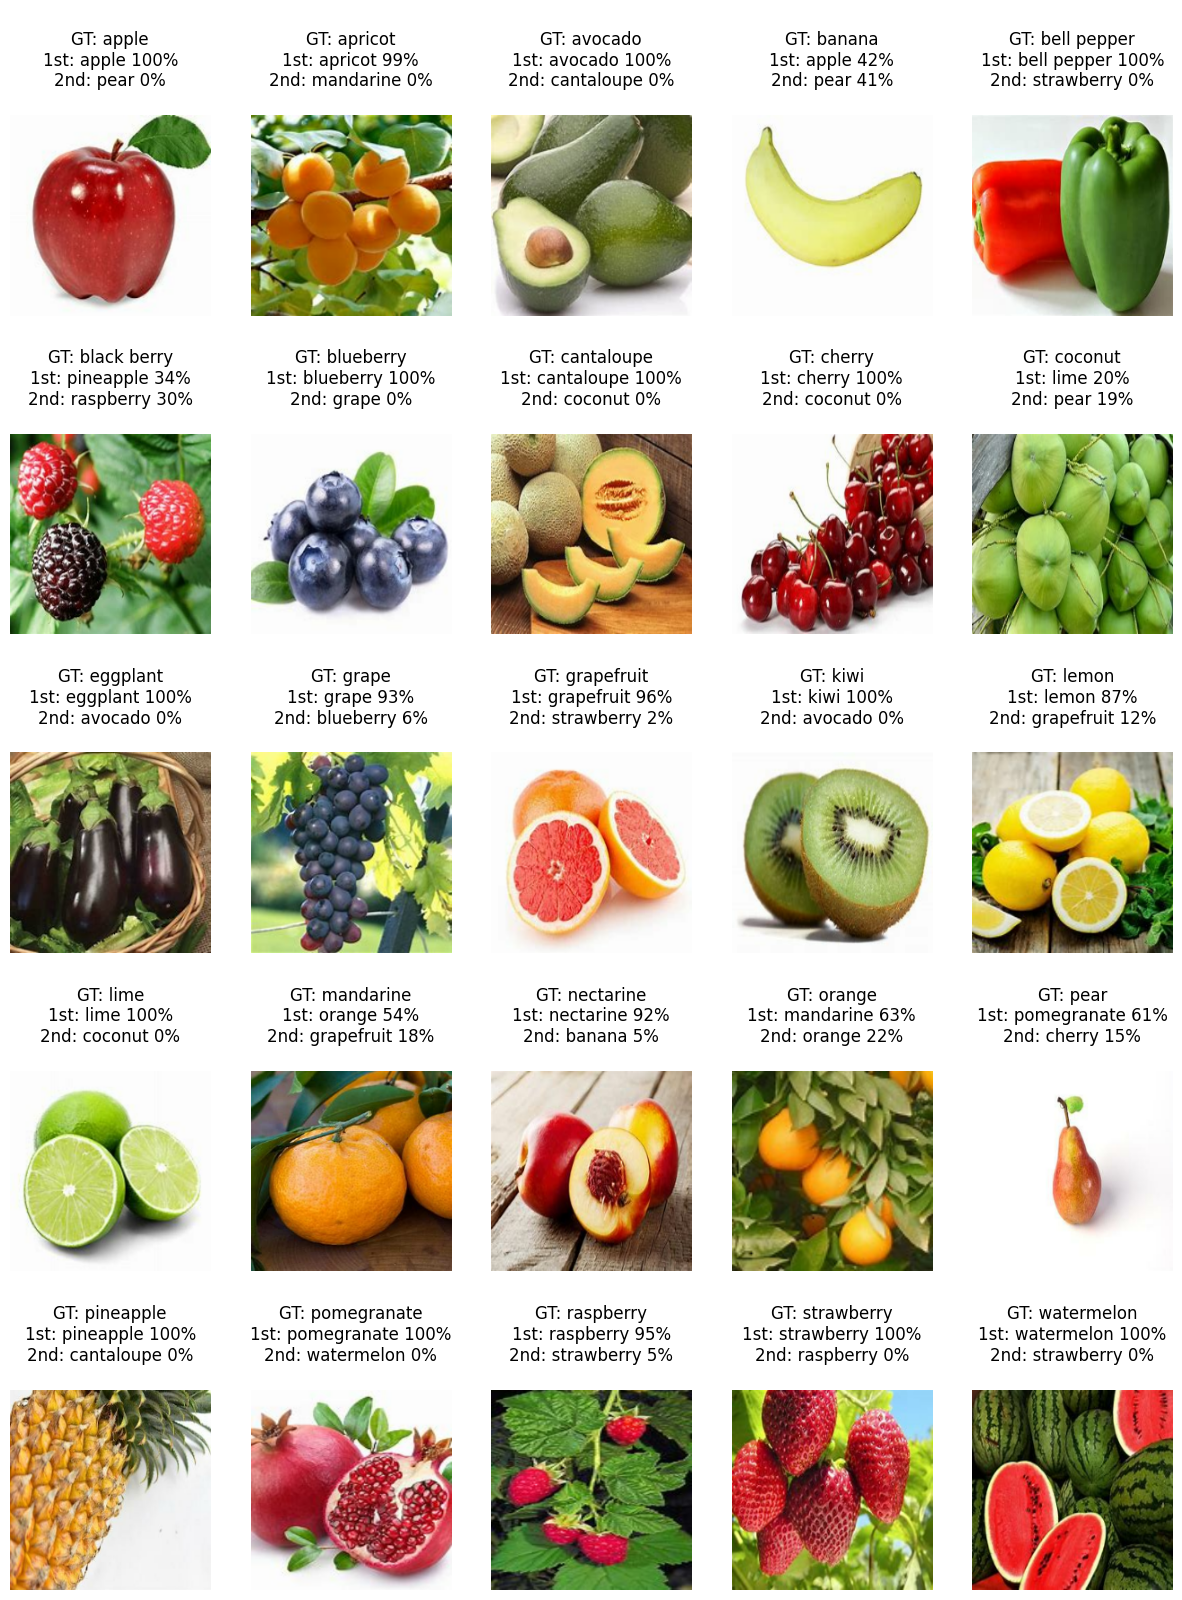

In [12]:
run('20230528-022341-2')